<a href="https://colab.research.google.com/github/abhishekmishra-bareilly/Deep-Learning/blob/main/age_gender_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d jangedoo/utkface-new

 94% 313M/331M [00:02<00:00, 125MB/s]
100% 331M/331M [00:03<00:00, 114MB/s]


In [6]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [7]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [8]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

## arrenge dataset 

In [9]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [10]:
len(age)

23708

In [11]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [12]:
df.shape

(23708, 3)

In [13]:
df.head()

,age,gender,img
0,37,0,37_0_0_20170104205841436.jpg.chip.jpg
1,3,1,3_1_0_20170109191833465.jpg.chip.jpg
2,18,1,18_1_0_20170117140440920.jpg.chip.jpg
3,1,0,1_0_3_20161219225633088.jpg.chip.jpg
4,39,0,39_0_3_20170119160257563.jpg.chip.jpg


In [14]:
# Creating train and test dataset
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [15]:
train_df.shape

(20000, 3)

In [16]:
test_df.shape

(3708, 3)

## Using data augemantation for data increasing

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


## using ResNet50 model
 

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [20]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

94765736/94765736 [==============================] - 1s 0us/step


In [21]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [23]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

In [24]:
# Check model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

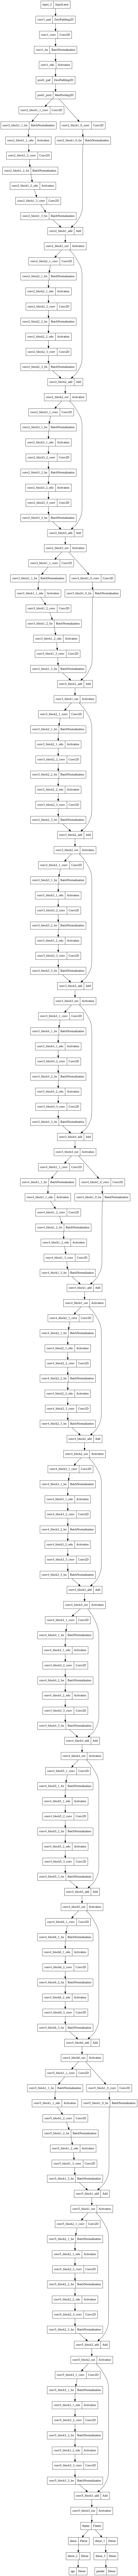

In [25]:
from keras.utils import plot_model
plot_model(model)

In [26]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [27]:
model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 232s 353ms/step - loss: 96.8054 - age_loss: 15.3829 - gender_loss: 0.8224 - age_mae: 15.3829 - gender_accuracy: 0.5105 - val_loss: 83.5517 - val_age_loss: 15.0321 - val_gender_loss: 0.6921 - val_age_mae: 15.0321 - val_gender_accuracy: 0.5227
Epoch 2/10
625/625 [==============================] - 214s 343ms/step - loss: 83.6345 - age_loss: 15.0827 - gender_loss: 0.6924 - age_mae: 15.0827 - gender_accuracy: 0.5221 - val_loss: 83.9711 - val_age_loss: 15.4247 - val_gender_loss: 0.6924 - val_age_mae: 15.4247 - val_gender_accuracy: 0.5227
Epoch 3/10
625/625 [==============================] - 213s 340ms/step - loss: 83.6195 - age_loss: 14.8856 - gender_loss: 0.6943 - age_mae: 14.8856 - gender_accuracy: 0.5225 - val_loss: 83.1340 - val_age_loss: 14.6125 - val_gender_loss: 0.6921 - val_age_mae: 14.6125 - val_gender_accuracy: 0.5227
Epoch 4/10
625/625 [==============================] - 214s 343ms/step - loss: 83.4316 - age_loss: 14.8892 - gend